In [ ]:
import numpy as np

def morlet_wavelet(t, w=5.0, s=1.0):
    """
    改进的Morlet小波函数。
    参数:
    - t : 时间数组
    - w : 频率参数
    - s : 尺度参数，影响小波的宽度
    """
    return np.exp(-0.5 * (t / s)**2) * np.cos(w * t)

def continuous_wavelet_transform(signal, scales, wavelet_function, dt=1.0):
    n = len(signal)
    t = np.linspace(-n/2, n/2, n) * dt  # 对称时间数组
    coefficients = np.zeros((len(scales), n))
    
    for i, scale in enumerate(scales):
        # 计算缩放后的小波
        scaled_t = t / scale
        wavelet_data = wavelet_function(scaled_t, s=scale)
        wavelet_data /= np.sqrt(scale) * (np.pi**(-0.25))  # 归一化
        
        # 计算卷积
        coefficients[i, :] = np.convolve(signal, wavelet_data, mode='same')
    
    return coefficients


In [ ]:
import matplotlib.pyplot as plt

# 创建一个测试信号
t = np.linspace(0, 1, 400, endpoint=False)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t)

# 定义缩放系数
scales = np.arange(1, 31)

# 计算CWT
cwt = continuous_wavelet_transform(signal, scales, morlet_wavelet)

# 绘制结果
plt.imshow(cwt, extent=[0, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
plt.colorbar()
plt.title('Continuous Wavelet Transform')
plt.ylabel('Scale')
plt.xlabel('Time')
plt.show()


In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# 创建信号
t = np.linspace(0, 1, 400, endpoint=False)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 20 * t)

# 设置小波和尺度
wavelet = 'cmor'  # 复数Morlet小波
scales = np.arange(1, 20)

# 计算CWT
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=1/400)

# 绘制结果
plt.imshow(np.abs(coefficients), extent=[0, 1, 1, 20], cmap='PRGn', aspect='auto',
           vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
plt.colorbar()
plt.title('Continuous Wavelet Transform using PyWavelets')
plt.ylabel('Scale')
plt.xlabel('Time')
plt.show()

In [ ]:
import pywt
import numpy as np

# 创建一个简单的信号
signal = np.sin(2 * np.pi * np.linspace(0, 1, 100)) + np.random.normal(0, 0.5, 100)

# 选择小波类型和层数
wavelet = 'db1'  # Daubechies小波，可以根据需要更换
levels = 2       # 变换的层数

# 进行离散小波变换
coeffs = pywt.wavedec(signal, wavelet, level=levels)

# coeffs是一个列表，其中包含每一层的详细系数和近似系数
cA = coeffs[0]  # 近似系数
cD = coeffs[1:]  # 详细系数列表

# 打印结果
print("近似系数 (cA):", cA)
for i, cd in enumerate(cD, 1):
    print(f"详细系数 Level {i} (cD):", cd)

# # 可选：重构信号
# reconstructed_signal = pywt.waverec(coeffs, wavelet)

# # 检查原始信号和重构信号
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.subplot(211)
# plt.title('Original Signal')
# plt.plot(signal)
# plt.subplot(212)
# plt.title('Reconstructed Signal')
# plt.plot(reconstructed_signal)
# plt.tight_layout()
# plt.show()

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def wcodemat(cfd, nbcol):
    # Normalize the data to 0-1
    cfd_normalized = (cfd - np.min(cfd)) / (np.max(cfd) - np.min(cfd))
    # Scale the data to use the full colormap range
    cfd_scaled = np.uint8(cfd_normalized * (nbcol - 1))
    return cfd_scaled

# 创建一个信号
fs = 200
f1 = 10
f2 = 40
t = np.arange(0, 1 + 1/fs, 1/fs)
s1 = 2 * np.sin(2 * np.pi * f1 * t)  # 0.5 * np.sin(2 * np.pi * f2 * t) (if needed)
s2 = 2 * np.sin(2 * np.pi * f2 * t) + 2 * np.sin(2 * np.pi * f1 * t)
s3 = 2 * np.sin(2 * np.pi * 2 * f2 * t)
signal = np.concatenate((s1, s2))

# 选择小波和分解层数
wavelet = 'db1'
levels = 5

# 进行离散小波变换
coeffs = pywt.wavedec(signal, wavelet, level=levels)

# Prepare to process coefficients
lev = len(coeffs) - 1  # excluding the approximation coefficients at the last index
len_target = len(coeffs[lev])  # Taking the length of the first level of detail coefficients

cfd = np.zeros((lev, len_target))

# Process each level's detail coefficients
for kk in range(lev):
    k = kk+1
    d = coeffs[k]
    # print(d)
    # Replicate each coefficient 2^k times vertically
    d_replicated = np.repeat(d, 2**(lev-kk+1))
    # Keep only the first 'len_target' coefficients
    if len(d_replicated) > len_target:
        d_kept = d_replicated[:len_target]
    else:
        d_kept = np.pad(d_replicated, (0, len_target - len(d_replicated)), 'constant')
    cfd[kk, :] = d_kept
print(cfd)
# Flatten, threshold small values, and reshape
cfd_flat = cfd.flatten()
print(cfd_flat)
threshold = np.sqrt(np.finfo(float).eps)
cfd_flat[np.abs(cfd_flat) < threshold] = 0
cfd = cfd_flat.reshape(lev, len_target)
nbcol = 64  # Number of colors
cfd = wcodemat(cfd, nbcol)

print(cfd.shape)

# Visualization
plt.figure()
plt.imshow(cfd, aspect='auto', interpolation='none', cmap='jet',norm=colors.Normalize(vmin=0, vmax=nbcol-1))
plt.colorbar()
plt.title('Detail Coefficients Across Levels')
plt.xlabel('Coefficient Index')
plt.ylabel('Level')
plt.show()

# # 准备数据绘图
# fig, axs = plt.subplots(levels + 1, 1, figsize=(10, 10), sharex=True)
# axs[0].plot(signal)
# axs[0].set_title('Original Signal')
# for i in range(1, levels + 1):
#     axs[i].plot(coeffs[i], label=f'Detail {i}')
#     axs[i].set_title(f'Level {i} Detail Coefficients')
#     axs[i].legend()

# plt.tight_layout()
# plt.show()

# # 设置小波和尺度
# wavelet = 'cmor'  # 复数Morlet小波
# scales = np.arange(1, 44)

# # 计算CWT
# coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=1/500)

# # 绘制结果
# plt.imshow(np.abs(coefficients), extent=[0, 1, 1, 44], cmap='PRGn', aspect='auto',
#            vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
# plt.colorbar()
# plt.title('Continuous Wavelet Transform using PyWavelets')
# plt.ylabel('Scale')
# plt.xlabel('Time')
# plt.show()

In [ ]:
import pywt
import numpy as np

# 示例信号生成（含噪声）
fs = 500                                # 采样频率
t = np.linspace(0, 1, fs)               # 离散采样时间序列
freq = 5                                # 信号频率
s1 = np.sin(2 * np.pi * freq * t)   # 纯净信号
s2 = np.sin(2 * np.pi * 2*freq * t)   # 纯净信号
signal = s1 + s2

noise = 0.2 * np.random.randn(fs)       # 随机噪声
noisy_signal = signal + noise           # 含噪声的信号

# 小波去噪
def wavelet_denoising(data, wavelet, level):
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
    sigma = (1/0.6745) * np.median(np.abs(coeff[-1] - np.median(coeff[-1])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
    return reconstructed_signal

def lowpassfilter(signal, thresh = 0.5, wavelet="db22"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    c1 = coeff.copy()
    # print(c1)
    # coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard" ) for i in coeff[1:])
    c2 = coeff
    # print(c2)
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal, c1, c2

# 使用db1小波进行去噪
denoised_signal = noisy_signal
for i in range(1):
    denoised_signal,c1, c2 = lowpassfilter(noisy_signal)
    
plt.figure()   
for i in range(len(c1)):
    plt.subplot(len(c1), 1,  i+1)
    plt.plot(c1[i])
    plt.plot(c2[i])


# 可视化结果
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.plot(t, signal, label='Original Signal')
plt.legend()
plt.subplot(312)
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.legend()
plt.subplot(313)
plt.plot(t, denoised_signal, label='Denoised Signal')
plt.legend()
plt.show()


# 信号重构步骤

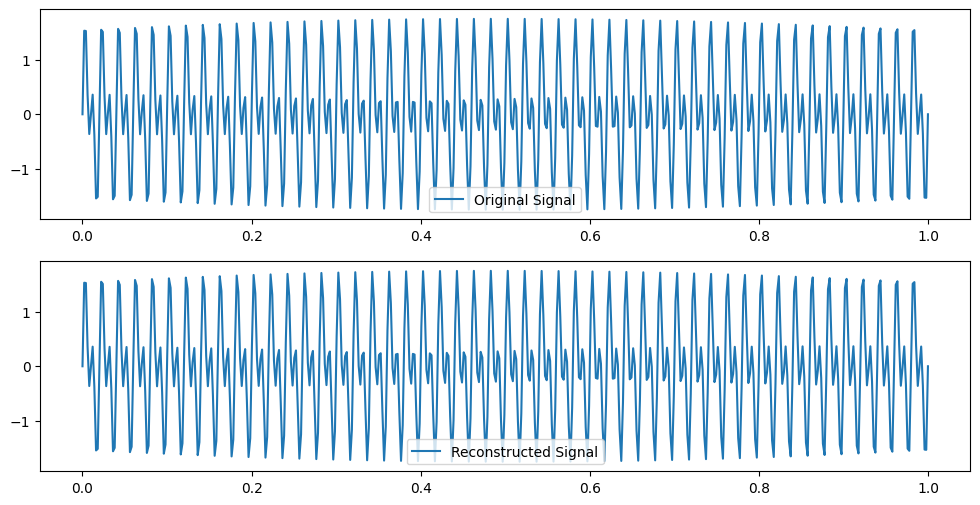

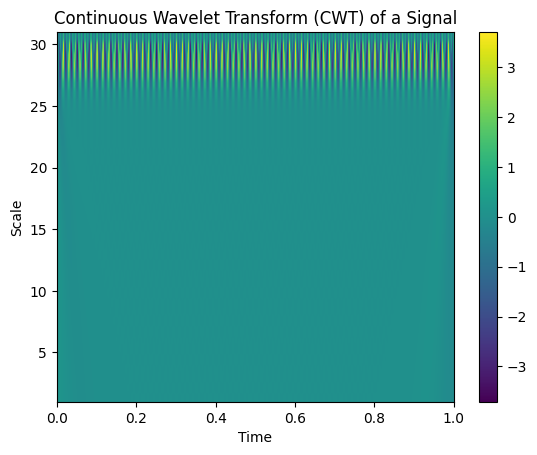

In [152]:
import pywt
import numpy as np

# 创建一个简单的信号
t = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 100 * t)

# 进行离散小波变换
coeffs = pywt.wavedec(signal, 'db1', level=4)

# 信号重构
reconstructed_signal = pywt.waverec(coeffs, 'db1')

# 比较原始信号和重构信号
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, signal, label='Original Signal')
plt.legend()
plt.subplot(212)
plt.plot(t, reconstructed_signal, label='Reconstructed Signal')
plt.legend()
plt.show()


# 设置小波和尺度
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 创建一个信号
t = np.linspace(0, 1, 1000, endpoint=False)
signal2 = np.cos(2 * np.pi * 70 * t) + np.cos(2 * np.pi * 130 * t)

# 定义小波和尺度
widths = np.arange(1, 40)
wavelet_type = 'cmor3-3'  # 使用墨西哥帽小波（Mexican hat wavelet）

# 进行连续小波变换
cwtmatr = signal.cwt(signal2, signal.ricker, widths)

# 可视化结果
plt.imshow(cwtmatr, extent=[0, 1, 1, 31], aspect='auto')
plt.colorbar()
plt.title('Continuous Wavelet Transform (CWT) of a Signal')
plt.ylabel('Scale')
plt.xlabel('Time')
plt.show()
